In [1]:
# import njit from numba
from numba import njit
# import np
import numpy as np

# initialize params with Dict of numba

from numba import types
from numba.typed import Dict

# randomseed
np.random.seed(0)

# import plt
import matplotlib.pyplot as plt

In [2]:
@njit
def get_norm(X):
    return np.sqrt(np.sum(X**2, axis=1))


# get distance2
@njit
def get_norm2(X):
    return np.sum(X**2, axis=1)

@njit
def get_relative_distance(X):
    relative_dist = np.zeros(int(X.shape[0]*(X.shape[0]-1)/2))
    for i in range(X.shape[0]):
        for j in range(i):
            relative_dist[i*(i-1)//2+j] = np.sqrt(np.sum((X[i]-X[j])**2))
    return relative_dist


# nn is a function that from X and params g
@njit
def nn(X, params):
    # non interactive part
    W0 = params['W0']

    norm2 = get_norm2(X)

    z0 = np.dot(W0, norm2) 

    # interactive part, use relative distance and tanh
    W1 = params['W1']
    b1 = params['b1']
    relative_dist = get_relative_distance(X)
    relative_dist = relative_dist[:, np.newaxis]
    z1 = np.dot(W1, relative_dist) + b1
    a1 = np.tanh(z1)

    W2 = params['W2']
    b2 = params['b2']
    z2 = np.dot(W2, a1) + b2
    a2 = np.tanh(z2)

    gamma = params['gamma']
    
    return z0 + gamma*a2

In [3]:



# define a function that help to produce params from the number of particles and dimension
# the hidden number of neuron
def init_params_rand(N, D, H):
    params = Dict.empty(
        key_type=types.unicode_type,
        # value type can be 1D or 2D array
        value_type = types.float64[:,:]
    )
    params['W0'] = np.random.randn(1, N)

    params['W1'] = np.random.randn(H, int(N*(N-1)/2))
    params['b1'] = np.random.randn(H,1)

    params['W2'] = np.random.randn(1, H)
    params['b2'] = np.random.randn(1,1)

    params['gamma'] = np.random.randn(1,1)

    return params

# init_params_W0_ones and all the rest is zero
def init_params_W0_ones(N, D, H):
    params = Dict.empty(
        key_type=types.unicode_type,
        # value type can be 1D or 2D array
        value_type = types.float64[:,:]
    )
    params['W0'] = -np.ones((1, N))

    params['W1'] = np.zeros((H, int(N*(N-1)/2)))
    params['b1'] = np.zeros((H,1))

    params['W2'] = np.zeros((1, H))
    params['b2'] = np.zeros((1,1))

    params['gamma'] = np.zeros((1,1))

    return params


def init_params_zeros(N, D, H):
    params = Dict.empty(
        key_type=types.unicode_type,
        # value type can be 1D or 2D array
        value_type = types.float64[:,:]
    )
    params['W0'] = np.zeros((1, N))

    params['W1'] = np.zeros((H, int(N*(N-1)/2)))
    params['b1'] = np.zeros((H,1))

    params['W2'] = np.zeros((1, H))
    params['b2'] = np.zeros((1,1))

    params['gamma'] = np.zeros((1,1)) + 1

    return params

In [4]:
@njit
def psi_nn(X, params):
    return np.exp(nn(X, params))

In [5]:
def nn_grad_params(X, params, grad, h=1e-5):
    for key in params:
        if len(params[key].shape) == 1:
            for i in range(params[key].shape[0]):
                params[key][i] += h
                f_plus = nn(X, params)
                params[key][i] -= 2*h
                f_minus = nn(X, params)
                params[key][i] += h
                grad[key][i] = (f_plus - f_minus)/(2*h)
        else:
            for i in range(params[key].shape[0]):
                for j in range(params[key].shape[1]):
                    params[key][i, j] += h
                    f_plus = nn(X, params)
                    params[key][i, j] -= 2*h
                    f_minus = nn(X, params)
                    params[key][i, j] += h
                    grad[key][i, j] = (f_plus - f_minus)/(2*h)

    return grad

In [6]:
def local_kinetic_energy(X, params, h=1e-5):
    grad = np.zeros(X.shape)
    laplacian = 0
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i, j] += h
            f_plus = nn(X, params)
            X[i, j] -= 2*h
            f_minus = nn(X, params)
            X[i, j] += h
            grad[i, j] = (f_plus - f_minus)/(2*h)
            laplacian += (f_plus - 2*nn(X, params) + f_minus)/h**2
    return -0.5*(laplacian + np.sum(grad**2))

/tmp/ipykernel_4729/3520295008.py:28: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  z0 = np.dot(W0, norm2)
/tmp/ipykernel_4729/3520295008.py:35: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  z1 = np.dot(W1, relative_dist) + b1
/tmp/ipykernel_4729/3520295008.py:40: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  z2 = np.dot(W2, a1) + b2


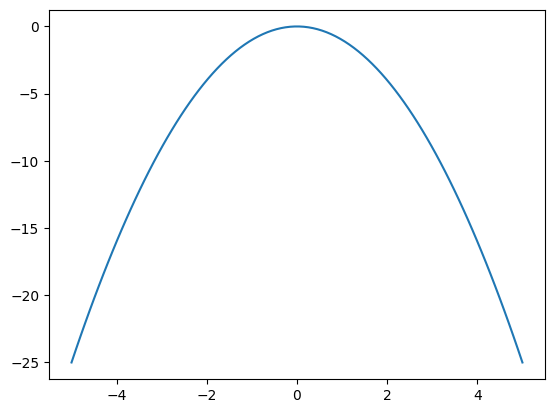

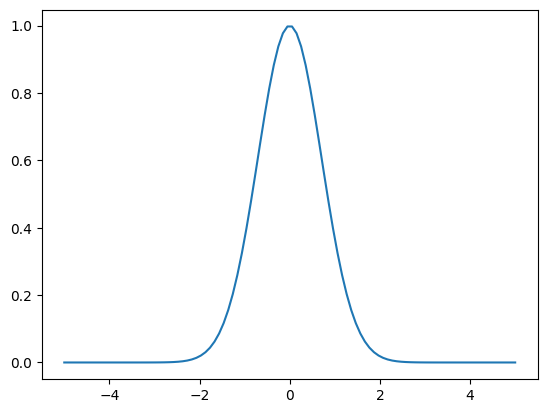

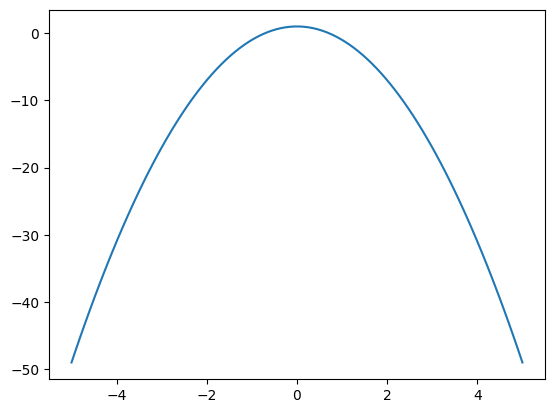

In [7]:
# print nn for X linspace
N = 1
D = 1
H = 1
X = np.linspace(-5, 5, 100).reshape(-1, 1)
params = init_params_W0_ones(N, D, H)
y = np.zeros(X.shape)

for i in range(X.shape[0]):
    y[i] = nn(X[i].reshape(1, 1), params)

plt.figure()
plt.plot(X, y)

# plot psi_nn
y = np.zeros(X.shape)
for i in range(X.shape[0]):
    y[i] = psi_nn(X[i].reshape(1, 1), params)

plt.figure()
plt.plot(X, y)

# plot local_kinetic_energy
y = np.zeros(X.shape)
for i in range(X.shape[0]):
    y[i] = local_kinetic_energy(X[i].reshape(1, 1), params)

plt.figure()
plt.plot(X, y)

In [8]:
N = 3
D = 2
H = 2

X = np.random.randn(N, D)

params = init_params_rand(N, D, H)
grad = init_params_rand(N, D, H)
print(nn(X, params))

grad = nn_grad_params(X, params, grad)
print(grad)

[[3.36085337]]
{W0: [[3.27200647 5.97953037 4.4428449 ]], W1: [[ 1.01527675e-05  7.00768332e-06  1.69376513e-05]
 [-3.38793082e-04 -2.33843656e-04 -5.65201708e-04]], b1: [[ 5.07320852e-06]
 [-1.69290160e-04]], W2: [[-1.53034439 -1.53008635]], b2: [[-1.53035675]], gamma: [[-0.63290041]]}


In [9]:
# def metropolis algorithm,
# input nn (log of wavefunction), params, N, D, H, nsteps, step_size
def metropolis(N, D, 
               nn, params, 
               nsteps, step_size=0.1):
    X = np.random.randn(N, D)
    X_new = np.zeros(X.shape)
    X_chain = np.zeros((nsteps, N, D))
    for i in range(nsteps):
        X_new = X + step_size*np.random.randn(N, D)
        if np.random.rand() < np.exp(2*(nn(X_new, params) - nn(X, params))):
            X = X_new
        X_chain[i] = X
    return X_chain

In [10]:
# test metropolis
N = 1
D = 1
H = 1

params = init_params_W0_ones(N, D, H)
X_chain = metropolis(N, D, nn, params, 2000, 0.1)

In [11]:
X_chain.shape

(2000, 1, 1)

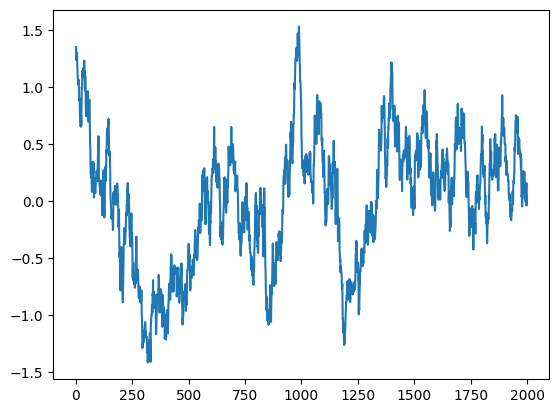

In [12]:
# plot the chain
plt.figure()
plt.plot(X_chain[:, 0, 0])

(array([0.04237395, 0.02542437, 0.11017228, 0.11864707, 0.11017228,
        0.1864454 , 0.19492019, 0.1864454 , 0.24576893, 0.25424372,
        0.55086139, 0.43221433, 0.364416  , 0.39831516, 0.28814288,
        0.33899163, 0.31356726, 0.31356726, 0.40678995, 0.41526474,
        0.51696223, 0.58476056, 0.62713451, 0.57628577, 0.65255888,
        0.73730679, 0.84747907, 0.8220547 , 0.9068026 , 0.78815553,
        0.72035721, 0.60171014, 0.50001265, 0.49153786, 0.38136558,
        0.34746642, 0.40678995, 0.26271851, 0.15254623, 0.10169749,
        0.08474791, 0.07627312, 0.11864707, 0.0932227 , 0.06779833,
        0.06779833, 0.04237395, 0.02542437, 0.03389916, 0.01694958]),
 array([-1.41913491, -1.36013641, -1.3011379 , -1.24213939, -1.18314089,
        -1.12414238, -1.06514387, -1.00614536, -0.94714686, -0.88814835,
        -0.82914984, -0.77015133, -0.71115283, -0.65215432, -0.59315581,
        -0.53415731, -0.4751588 , -0.41616029, -0.35716178, -0.29816328,
        -0.23916477, -0.18

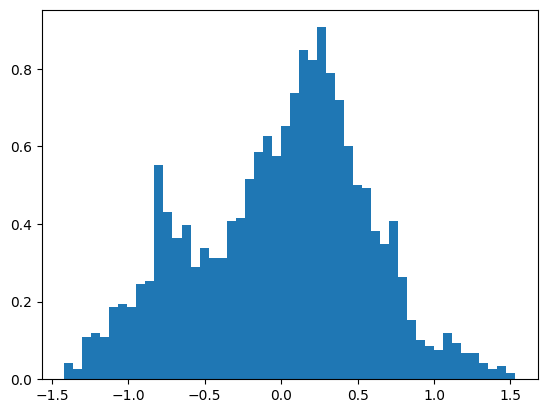

In [13]:
# histogram of X_chain
plt.figure()
plt.hist(X_chain[:,0,0], bins=50, density=True)

In [14]:
# def local energies, from chain and params get the sum of local kinetic energy and local potential energy
@njit
def local_potential_energy(X):
    return 0.5*np.sum(X**2)

def local_energies(N, D, X_chain, params, local_kinetic_energy):
    local_energies = np.zeros(X_chain.shape[0])
    for i in range(X_chain.shape[0]):
        local_energies[i] = local_kinetic_energy(X_chain[i].reshape(N, D), params) + local_potential_energy(X_chain[i].reshape(N, D))
    return local_energies

In [15]:
# test local_energies
energies = local_energies(N, D, X_chain, params, local_kinetic_energy)

In [16]:
np.mean(energies)

0.5230301838100038

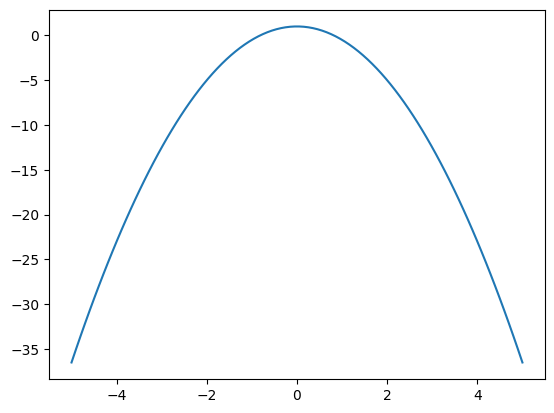

In [17]:
# print the local energy for X = np.linspace(-5, 5, 100).reshape(-1, 1)

X = np.linspace(-5, 5, 100).reshape(-1, 1)
energies = np.zeros(X.shape)
for i in range(X.shape[0]):
    energies[i] = local_kinetic_energy(X[i].reshape(1, 1), params) + local_potential_energy(X[i].reshape(1, 1))

plt.figure()
plt.plot(X, energies)

In [18]:
# def a function that sum two params dictionary
@njit
def sum_params(params1, params2):
    params = Dict.empty(
        key_type=types.unicode_type,
        # value type can be 1D or 2D array
        value_type = types.float64[:,:]
    )
    for key in params1:
        params[key] = params1[key] + params2[key]
    return params

In [19]:
# def a func that multiply a params dictionary by a scalar
@njit
def scalar_mult_params(params, scalar):
    params_new = Dict.empty(
        key_type=types.unicode_type,
        # value type can be 1D or 2D array
        value_type = types.float64[:,:]
    )
    for key in params:
        params_new[key] = scalar*params[key]
    return params_new

In [20]:
# calculate the energy radient along parameters
def energy_grad_param(N, D, H,
                      X_chain, params, nn_grad_params, local_kinetic_energy, local_potential_energy):
    grad_params = init_params_zeros(N, D, H)
    first_term = init_params_zeros(N, D, H)
    second_term = init_params_zeros(N, D, H)
    energy_tot = 0
    for i in range(X_chain.shape[0]):
        local_energy = local_kinetic_energy(X_chain[i].reshape(N,D), params) + local_potential_energy(X_chain[i].reshape(N,D))
        grad_params = nn_grad_params(X_chain[i].reshape(N,D), params, grad_params)
        first_term = sum_params(first_term, scalar_mult_params(grad_params, local_energy))
        second_term = sum_params(second_term, scalar_mult_params(grad_params, 1))
        energy_tot += local_energy 
    
    first_term = scalar_mult_params(first_term, 1/X_chain.shape[0])
    second_term = scalar_mult_params(second_term, energy_tot/(X_chain.shape[0]**2))
    sum_term = sum_params(first_term, scalar_mult_params(second_term, -1))

    return sum_term

In [21]:
# test with the chain that we have
grad_params = energy_grad_param(N, D, H, X_chain, params, nn_grad_params, local_kinetic_energy, local_potential_energy)

In [22]:
grad_params

DictType[unicode_type,array(float64, 2d, A)]<iv=None>({W0: [[-0.23985354]], W1: [], b1: [[0.]], W2: [[0.]], b2: [[0.]], gamma: [[0.00023848]]})

In [23]:
# def optimization, use batch step to obtain the energy gradient and update the params, do that for optimization step
# input 
# for step in optimization_step, get metropolis for batch_step, get energy_grad_param, update params using lr
def optimization(nn, params, N, D, H, nn_grad_params, local_kinetic_energy, local_potential_energy, optimization_steps, batch_size, lr=0.01):
    for i in range(optimization_steps):
        print("params",params)
        X_chain = metropolis(N, D, nn, params, batch_size, 0.1)
        grad_params = energy_grad_param(N, D, H, X_chain, params, nn_grad_params, local_kinetic_energy, local_potential_energy)
        print("grad_params", grad_params)
        for key in params:
            params[key] = params[key] - lr*grad_params[key]
    return params

In [24]:
# test, start with params = 0.45
N = 1
D = 1
H = 1

optimization_steps = 50
lr = 0.1
batch_size = 500

params = init_params_W0_ones(N, D, H)
params = scalar_mult_params(params, 0.7)

params = optimization(nn, params, N, D, H, nn_grad_params, 
                      local_kinetic_energy, local_potential_energy, 
                      optimization_steps, batch_size, lr)

params {W0: [[-0.7]], W1: [], b1: [[0.]], W2: [[0.]], b2: [[0.]], gamma: [[0.]]}
grad_params {W0: [[-0.04612663]], W1: [], b1: [[0.]], W2: [[0.]], b2: [[0.]], gamma: [[0.00092241]]}
params {W0: [[-0.69538734]], W1: [], b1: [[0.]], W2: [[0.]], b2: [[0.]], gamma: [[-9.22410584e-05]]}
grad_params {W0: [[-0.13368022]], W1: [], b1: [[0.]], W2: [[0.]], b2: [[8.18240874e-14]], gamma: [[0.00106103]]}
params {W0: [[-0.68201931]], W1: [], b1: [[0.]], W2: [[0.]], b2: [[-8.18240874e-15]], gamma: [[-0.00019834]]}
grad_params {W0: [[-0.11303518]], W1: [], b1: [[0.]], W2: [[0.]], b2: [[1.31049062e-13]], gamma: [[0.00094456]]}
params {W0: [[-0.6707158]], W1: [], b1: [[0.]], W2: [[0.]], b2: [[-2.12873156e-14]], gamma: [[-0.0002928]]}
grad_params {W0: [[-1.06196452]], W1: [], b1: [[0.]], W2: [[0.]], b2: [[-1.78317341e-12]], gamma: [[0.00140064]]}
params {W0: [[-0.56451935]], W1: [], b1: [[0.]], W2: [[0.]], b2: [[1.57030026e-13]], gamma: [[-0.00043286]]}
grad_params {W0: [[-0.06224277]], W1: [], b1: [[0.

In [26]:
# test, start with params = 0.45
N = 3
D = 1
H = 1

optimization_steps = 50
lr = 0.05
batch_size = 1000

params = init_params_W0_ones(N, D, H)
params = scalar_mult_params(params, -0.6)
rand_params = init_params_rand(N, D, H)
params = sum_params(params, rand_params)

params = optimization(nn, params, N, D, H, nn_grad_params, 
                      local_kinetic_energy, local_potential_energy, 
                      optimization_steps, batch_size, lr)

params {W0: [[ 0.59496802 -0.36403541 -0.77922879]], W1: [[1.28495471 0.40206082 0.53065473]], b1: [[-0.18974672]], W2: [[-0.90254269]], b2: [[0.25920719]], gamma: [[-0.28226731]]}
grad_params {W0: [[-3.28689727e+04 -3.54400945e+02  1.58097323e+01]], W1: [[1.60047128e-04 1.93576920e-04 3.36085599e-05]], b1: [[5.43160729e-05]], W2: [[-7.35272128e-07]], b2: [[-3.08269198e-05]], gamma: [[0.0909421]]}
params {W0: [[ 1.64404360e+03  1.73560118e+01 -1.56971540e+00]], W1: [[1.2849467  0.40205114 0.53065305]], b1: [[-0.18974943]], W2: [[-0.90254266]], b2: [[0.25920873]], gamma: [[-0.28681442]]}


/tmp/ipykernel_4729/1718444509.py:11: RuntimeWarning: overflow encountered in exp
  if np.random.rand() < np.exp(2*(nn(X_new, params) - nn(X, params))):


grad_params {W0: [[-1.10983229e+12 -2.13077845e+10 -1.36231826e+08]], W1: [[ 71183.78202106 146117.16094688  74934.29599316]], b1: [[55636.6763836]], W2: [[-178.67643005]], b2: [[-31066.10070199]], gamma: [[2831384.44840407]]}
params {W0: [[5.54916163e+10 1.06538924e+09 6.81158973e+06]], W1: [[-3557.90415435 -7305.4559962  -3746.18414661]], b1: [[-2782.02356861]], W2: [[8.03127885]], b2: [[1553.56424383]], gamma: [[-141569.50923462]]}
grad_params {W0: [[-1.55312725e+27  4.13148593e+23 -1.27090975e+25]], W1: [[0. 0. 0.]], b1: [[0.]], W2: [[0.]], b2: [[0.]], gamma: [[1.34654807e+23]]}
params {W0: [[ 7.76563627e+25 -2.06574297e+22  6.35454876e+23]], W1: [[-3557.90415435 -7305.4559962  -3746.18414661]], b1: [[-2782.02356861]], W2: [[8.03127885]], b2: [[1553.56424383]], gamma: [[-6.73274034e+21]]}
grad_params {W0: [[0. 0. 0.]], W1: [[0. 0. 0.]], b1: [[0.]], W2: [[0.]], b2: [[0.]], gamma: [[6.60600849e+51]]}
params {W0: [[ 7.76563627e+25 -2.06574297e+22  6.35454876e+23]], W1: [[-3557.9041543

SystemError: CPUDispatcher(<function _getitem at 0x7fa5cc090550>) returned a result with an exception set

In [27]:
# def init_params_Wh_rand is W1, W2, b1, b2 and the rest zero, control with epsilon
def init_params_Wh_rand(N, D, H, epsilon=0.1):
    params = Dict.empty(
        key_type=types.unicode_type,
        # value type can be 1D or 2D array
        value_type = types.float64[:,:]
    )
    params['W0'] = np.zeros((1, N))

    params['W1'] = epsilon*np.random.randn(H, int(N*(N-1)/2))
    params['b1'] = epsilon*np.random.randn(H,1)

    params['W2'] = epsilon*np.random.randn(1, H)
    params['b2'] = epsilon*np.random.randn(1,1)

    params['gamma'] = epsilon*np.random.randn(1,1)

    return params

In [28]:
# def_init_params_gamma_ones, all zero except gamma
def init_params_gamma_one(N, D, H):
    params = Dict.empty(
        key_type=types.unicode_type,
        # value type can be 1D or 2D array
        value_type = types.float64[:,:]
    )
    params['W0'] = np.zeros((1, N))

    params['W1'] = np.zeros((H, int(N*(N-1)/2)))
    params['b1'] = np.zeros((H,1))

    params['W2'] = np.zeros((1, H))
    params['b2'] = np.zeros((1,1))

    params['gamma'] = np.ones((1,1))

    return params

In [29]:
# def_init_params_Guess, where W0 is alpha, Wh are random with epsilon, and gamma = gamma
def init_params_guess(N, D, H, alpha, epsilon=0.1, gamma=1):
    params = Dict.empty(
        key_type=types.unicode_type,
        # value type can be 1D or 2D array
        value_type = types.float64[:,:]
    )
    params['W0'] = alpha*np.ones((1, N))

    params['W1'] = epsilon*np.random.randn(H, int(N*(N-1)/2))
    params['b1'] = epsilon*np.random.randn(H,1)

    params['W2'] = epsilon*np.random.randn(1, H)
    params['b2'] = epsilon*np.random.randn(1,1)

    params['gamma'] = gamma*np.ones((1,1))

    return params

In [30]:

# optimization with init_params_guess
N = 3
D = 1
H = 1

optimization_steps = 50
lr = 0.1
batch_size = 1000

params = init_params_guess(N, D, H, -0.6, 0.1, 0.5)

params = optimization(nn, params, N, D, H, nn_grad_params,
                        local_kinetic_energy, local_potential_energy,
                        optimization_steps, batch_size, lr)


params {W0: [[-0.6 -0.6 -0.6]], W1: [[ 0.07694768  0.00073365 -0.12801722]], b1: [[-0.01791603]], W2: [[-0.01641032]], b2: [[0.11848884]], gamma: [[0.5]]}
grad_params {W0: [[-0.01742877 -0.06481827 -0.01091832]], W1: [[1.91337359e-04 6.02206710e-05 2.58177483e-04]], b1: [[-3.56951683e-06]], W2: [[0.00113207]], b2: [[4.44018107e-06]], gamma: [[-0.00064005]]}
params {W0: [[-0.59825712 -0.59351817 -0.59890817]], W1: [[ 0.07692855  0.00072763 -0.12804303]], b1: [[-0.01791567]], W2: [[-0.01652353]], b2: [[0.1184884]], gamma: [[0.500064]]}
grad_params {W0: [[-0.16372668 -0.01217583 -0.00599955]], W1: [[5.53637032e-04 8.14482368e-04 6.20598441e-05]], b1: [[-5.52735573e-06]], W2: [[-0.00215813]], b2: [[-8.31635035e-06]], gamma: [[-0.00048159]]}
params {W0: [[-0.58188446 -0.59230059 -0.59830821]], W1: [[ 0.07687318  0.00064618 -0.12804924]], b1: [[-0.01791512]], W2: [[-0.01630772]], b2: [[0.11848923]], gamma: [[0.50011216]]}
grad_params {W0: [[-0.02183809 -0.03567303 -0.06630838]], W1: [[1.9022

In [ ]:
# define a function that from a chain get the sum of all the square of psi_nn for n_steps given params
def Z_tot(N, D, psi_nn, params, chain):
    Z = 0
    for i in range(chain.shape[0]):
        Z += psi_nn(chain[i].reshape(N, D), params)**2
    return Z

In [ ]:
# test
chain = metropolis(N, D, psi_nn, params, 1000, 0.1)
Z = Z_tot(N, D, psi_nn, params, chain)
Z

array([[114.11194337]])

In [ ]:
# def a function that from params give params with gamma = 0
def params_no_gamma(params):
    params_no_gamma = Dict.empty(
        key_type=types.unicode_type,
        # value type can be 1D or 2D array
        value_type = types.float64[:,:]
    )
    for key in params:
        if key != 'gamma':
            params_no_gamma[key] = params[key]
        else :
            params_no_gamma[key] = np.zeros((1,1))
    return params_no_gamma

# get Z_tot from no gamma params
Z_no_gamma = Z_tot(N, D, psi_nn, params_no_gamma(params), chain)
Z_no_gamma

array([[140.86700272]])

In [ ]:
# give me the sequence for a chain of psi_nn**2 for gamma and gamma zero
def Z_chain(N, D, psi_nn, params, chain):
    Z_chain = np.zeros(chain.shape[0])
    for i in range(chain.shape[0]):
        Z_chain[i] = psi_nn(chain[i].reshape(N, D), params)**2
    return Z_chain

Z_chain_gamma = Z_chain(N, D, psi_nn, params, chain)
Z_chain_no_gamma = Z_chain(N, D, psi_nn, params_no_gamma(params), chain)

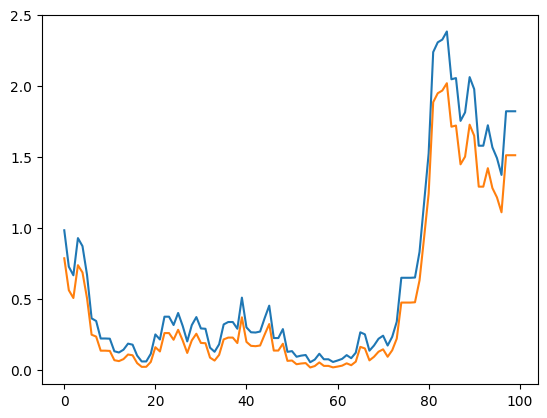

In [ ]:
# plot Z_chain_gamma and Z_chain_no_gamma
plt.figure()
plt.plot(Z_chain_gamma)
plt.plot(Z_chain_no_gamma)

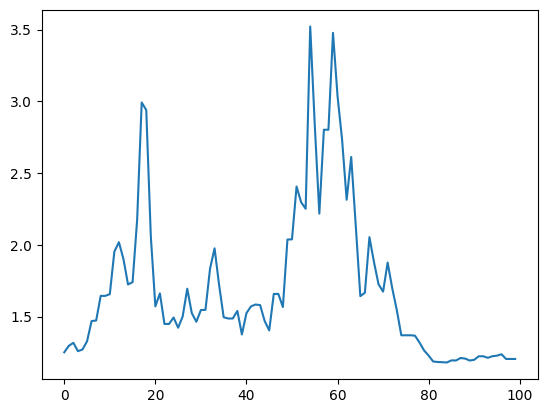

505.28059601047977
0.6860564185547492


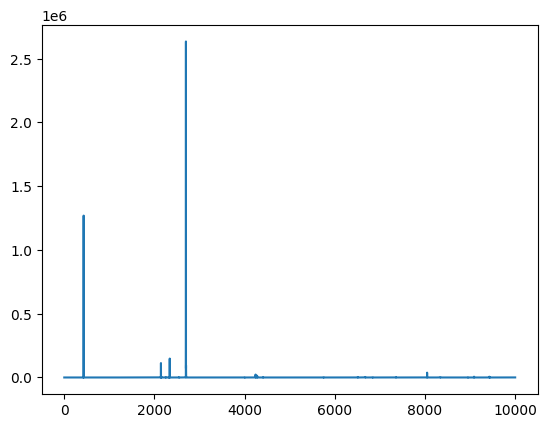

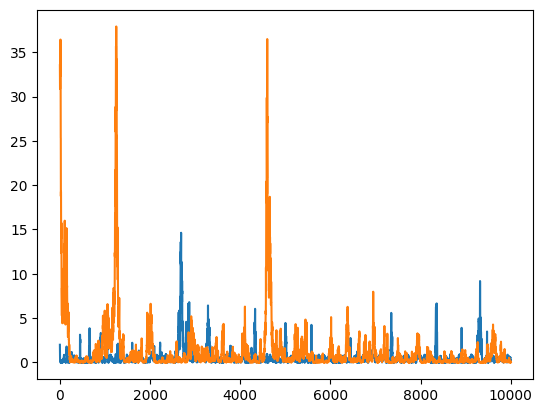

In [ ]:
params_gamma = init_params_guess(N, D, H, alpha=-0.6, epsilon=100000.0, gamma=1)
# get a new chain
chain_gamma = metropolis(N, D, nn, params_gamma, 10000, 0.1)
Z_chain_gamma = Z_chain(N, D, nn, params_gamma, chain_gamma)

chain_no_gamma = metropolis(N, D, nn, params_no_gamma(params_gamma), 10000, 0.1)
Z_chain_no_gamma = Z_chain(N, D, nn, params_no_gamma(params_gamma), chain_no_gamma)
# plot the ratio
# ratio
plt.figure()
plt.plot(Z_chain_gamma/Z_chain_no_gamma)

# plot Z_chain_gamma and Z_chain_no_gamma
plt.figure()
plt.plot(Z_chain_gamma)
plt.plot(Z_chain_no_gamma)

# print mean and median
print(np.mean(Z_chain_gamma/Z_chain_no_gamma))
print(np.median(Z_chain_gamma/Z_chain_no_gamma))

(array([0.0050516 , 0.01043997, 0.01077674, 0.00538837, 0.00976642,
        0.01246061, 0.01616511, 0.01919607, 0.02525799, 0.0676914 ,
        0.08351974, 0.08116233, 0.12224866, 0.16030402, 0.24954891,
        0.28423654, 0.3286906 , 0.38560526, 0.49034172, 0.55230798,
        0.5395106 , 0.58160724, 0.57756596, 0.59204721, 0.5758821 ,
        0.53109127, 0.56308472, 0.54422542, 0.48394303, 0.40715875,
        0.35798987, 0.30713712, 0.24988568, 0.21553482, 0.15491565,
        0.11719706, 0.1003584 , 0.07173268, 0.05960885, 0.04378051,
        0.03771859, 0.0188593 , 0.01212383, 0.0087561 , 0.01043997,
        0.00538837, 0.0050516 , 0.00404128, 0.00269419, 0.0037045 ]),
 array([-2.31341623, -2.21443764, -2.11545905, -2.01648045, -1.91750186,
        -1.81852327, -1.71954467, -1.62056608, -1.52158748, -1.42260889,
        -1.3236303 , -1.2246517 , -1.12567311, -1.02669452, -0.92771592,
        -0.82873733, -0.72975874, -0.63078014, -0.53180155, -0.43282296,
        -0.33384436, -0.23

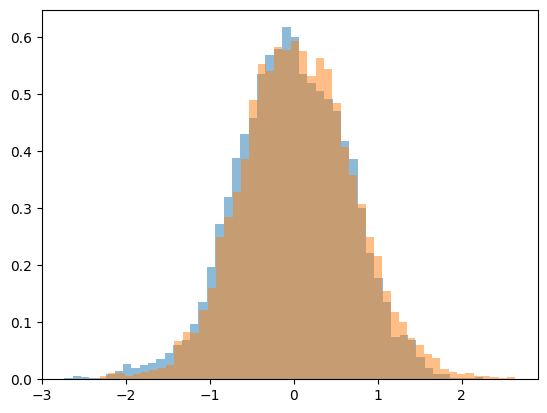

In [ ]:
# histgram the coordinate flatten off the two
plt.figure()
plt.hist(chain_gamma.flatten(), bins=50, density=True, alpha=0.5)
plt.hist(chain_no_gamma.flatten(), bins=50, density=True, alpha=0.5)

(array([0.0104877 , 0.0104877 , 0.        , 0.03146311, 0.04719466,
        0.07865776, 0.11012087, 0.12585242, 0.16780323, 0.17829093,
        0.29365565, 0.25694869, 0.35658186, 0.52438509, 0.55060434,
        0.55584819, 0.59255515, 0.62926211, 0.51914124, 0.67121291,
        0.66596906, 0.68694447, 0.67121291, 0.59255515, 0.64499366,
        0.49292198, 0.78657763, 0.52962894, 0.50865354, 0.52438509,
        0.39328882, 0.39853267, 0.36706956, 0.34085031, 0.2674364 ,
        0.26219254, 0.18877863, 0.20451018, 0.24121714, 0.24121714,
        0.18877863, 0.2779241 , 0.19402248, 0.09438932, 0.13634012,
        0.06292621, 0.02621925, 0.01573155, 0.0104877 , 0.00524385]),
 array([-1.63735635, -1.57378984, -1.51022332, -1.4466568 , -1.38309029,
        -1.31952377, -1.25595725, -1.19239074, -1.12882422, -1.0652577 ,
        -1.00169119, -0.93812467, -0.87455816, -0.81099164, -0.74742512,
        -0.68385861, -0.62029209, -0.55672557, -0.49315906, -0.42959254,
        -0.36602602, -0.30

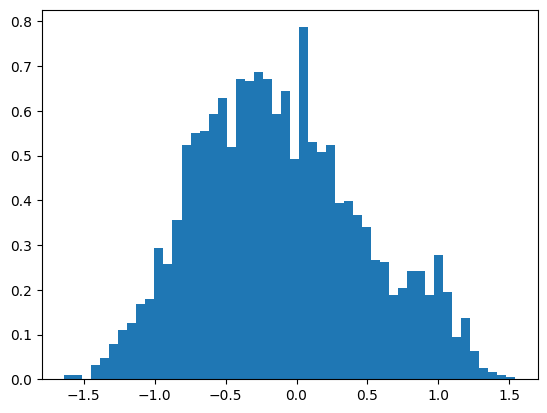

In [ ]:
# plot the histo of the coordinated of chain, flatten
plt.figure()
plt.hist(chain.flatten(), bins=50, density=True)

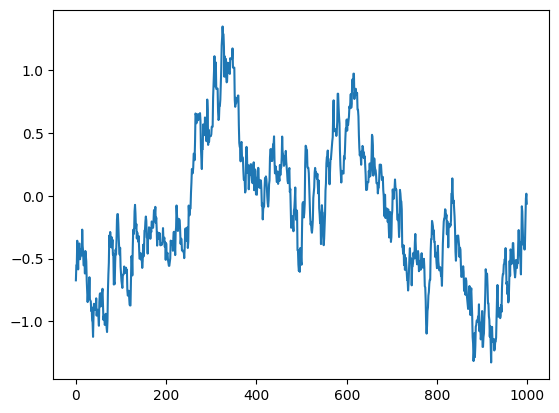

In [ ]:
# plot chain[:,0,0]
plt.figure()
plt.plot(chain[:,0,0])

In [ ]:
params

DictType[unicode_type,array(float64, 2d, A)]<iv=None>({W0: [[-0.6 -0.6 -0.6]], W1: [[-0.17738608 -0.00904662 -0.06204572]], b1: [[-0.04226415]], W2: [[0.11949414]], b2: [[-0.19650048]], gamma: [[0.5]]})

In [ ]:
chain_gamma.shape

(10000, 3, 1)

In [ ]:
# def put the b coef in params to zero
def params_no_b(params):
    params_no_b = Dict.empty(
        key_type=types.unicode_type,
        # value type can be 1D or 2D array
        value_type = types.float64[:,:]
    )
    for key in params:
        if key != 'b1' and key != 'b2':
            params_no_b[key] = params[key]
        else :
            params_no_b[key] = np.zeros(params[key].shape)
    return params_no_b


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-2.39832997, -2.29788671, -2.19744345, -2.0970002 , -1.99655694,
        -1.89611368, -1.79567043, -1.69522717, -1.59478391, -1.49434066,
        -1.3938974 , -1.29345414, -1.19301089, -1.09256763, -0.99212437,
        -0.89168112, -0.79123786, -0.6907946 , -0.59035135, -0.48990809,
        -0.38946483, -0.28902157, -0.18857832, -0.08813506,  0.0123082 ,
         0.11275145,  0.21319471,  0.31363797,  0.41408122,  0.51452448,
         0.61496774,  0.71541099,  0.81585425,  0.91629751,  1.01674076,
         1.11718402,  1.21762728,  1.31807053,  1.41851379,  1.51895705,
         1.6194003 ,  1.71984356,  1.82028682,  1.92073008,  2.02117333,
         2.12161659,  2.22205985,  2.3225031 ,  2.42294636,  2.52338962,
         2.62383287])

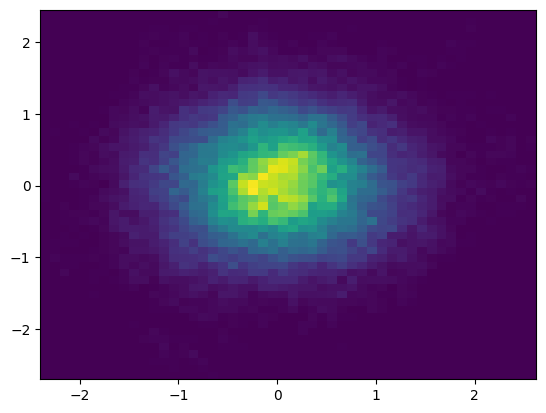

In [ ]:
# use a systen of N = 2, D =1, H = 1, show with gamma and without the histogram in 2D
N = 2
D = 1
H = 5

params = init_params_guess(N, D, H, alpha=-0.6, epsilon=0.0, gamma=0)
chain = metropolis(N, D, nn, params, 100000, 0.1)

plt.figure()
plt.hist2d(chain[:,0,0], chain[:,1,0], bins=50, density=True)



In [ ]:
# def put the b coef in params to zero
def params_no_b(params):
    params_no_b = Dict.empty(
        key_type=types.unicode_type,
        # value type can be 1D or 2D array
        value_type = types.float64[:,:]
    )
    for key in params:
        if key != 'b1' and key != 'b2':
            params_no_b[key] = params[key]
        else :
            params_no_b[key] = np.zeros(params[key].shape)
    return params_no_b


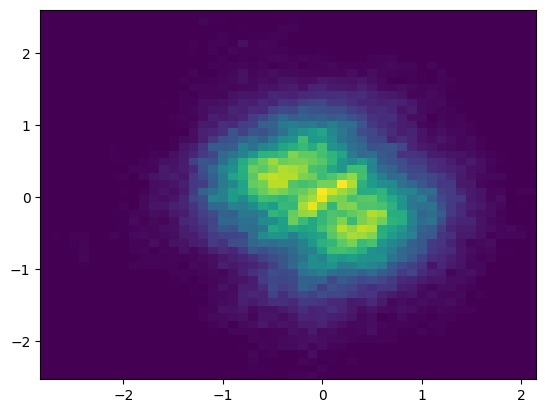

In [ ]:
# analize chain
params_gamma = init_params_guess(N, D, H, alpha=-0.6, epsilon=2., gamma=0.5)
chain_gamma = metropolis(N, D, nn, params_no_b(params_gamma), 100000, 0.1)

plt.figure()
h = plt.hist2d(chain_gamma[:,0,0], chain_gamma[:,1,0], bins=50, density=True)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-3.        , -2.87755102, -2.75510204, -2.63265306, -2.51020408,
        -2.3877551 , -2.26530612, -2.14285714, -2.02040816, -1.89795918,
        -1.7755102 , -1.65306122, -1.53061224, -1.40816327, -1.28571429,
        -1.16326531, -1.04081633, -0.91836735, -0.79591837, -0.67346939,
        -0.55102041, -0.42857143, -0.30612245, -0.18367347, -0.06122449,
         0.06122449,  0.18367347,  0.30612245,  0.42857143,  0.55102041,
         0.67346939,  0.79591837,  0.91836735,  1.04081633,  1.16326531,
         1.28571429,  1.40816327,  1.53061224,  1.65306122,  1.7755102 ,
         1.89795918,  2.02040816,  2.14285714,  2.26530612,  2.3877551 ,
         2.51020408,  2.63265306,  2.75510204,  2.87755102,  3.        ]),
 array([-3.        

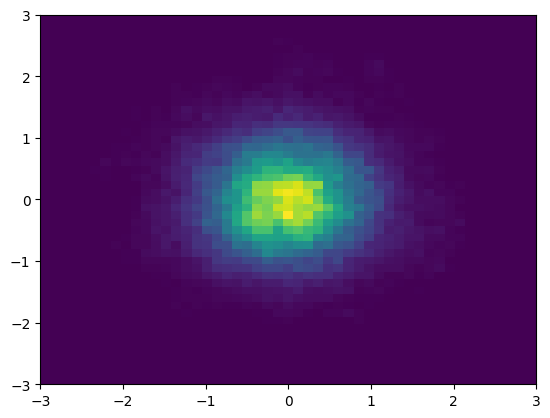

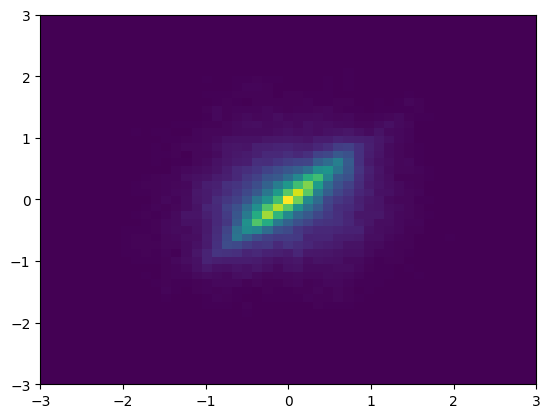

In [ ]:
# use the same grid to make an histogram density true of the two chain

x_bins = np.linspace(-3, 3, 50)
y_bins = np.linspace(-3, 3, 50)

plt.figure()
plt.hist2d(chain[:,0,0], chain[:,1,0], bins=(x_bins, y_bins), density=True)
# and chain_no_b
plt.figure()
plt.hist2d(chain_gamma[:,0,0], chain_gamma[:,1,0], bins=(x_bins, y_bins), density=True)

/tmp/ipykernel_28462/2820541317.py:8: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(hist_gamma/hist, origin='lower', extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]], aspect='auto')
/tmp/ipykernel_28462/2820541317.py:8: RuntimeWarning: invalid value encountered in divide
  plt.imshow(hist_gamma/hist, origin='lower', extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]], aspect='auto')


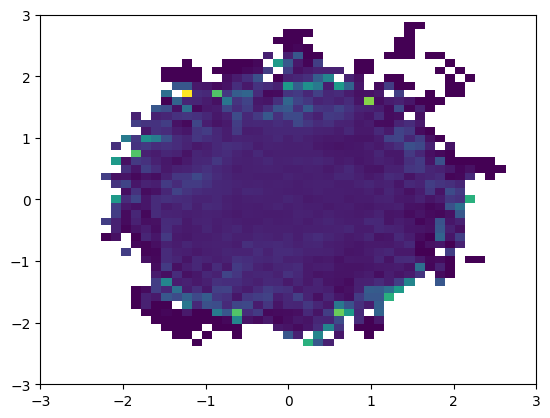

In [ ]:
# get the histo with np

hist, x_edges, y_edges = np.histogram2d(chain[:,0,0], chain[:,1,0], bins=(x_bins, y_bins), density=True)
hist_gamma, x_edges, y_edges = np.histogram2d(chain_gamma[:,0,0], chain_gamma[:,1,0], bins=(x_bins, y_bins), density=True)

# plot the ratio
plt.figure()
plt.imshow(hist_gamma/hist, origin='lower', extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]], aspect='auto')

In [ ]:
# get the sovrapposition, so get tot Z
Z = Z_tot(N, D, nn, params, chain)
Z_no_b = Z_tot(N, D, nn, params_no_b(params), chain_gamma)

In [ ]:
# the sovrapposition is psi_nn/sqrt(Z) * psi_nn(no_b)/sqrt(Z_no_b)

overlap = 0
# integrate the overlap using the grid of before
for i in range(len(x_bins)-1):
    for j in range(len(y_bins)-1):
        overlap += psi_nn(np.array([x_bins[i], y_bins[j]]).reshape(2, 1), params)/np.sqrt(Z)*psi_nn(np.array([x_bins[i], y_bins[j]]).reshape(2, 1), params_no_b(params))/np.sqrt(Z_no_b)*(x_bins[i+1]-x_bins[i])*(y_bins[j+1]-y_bins[j])
overlap

array([[5.30264105e-05]])